In [11]:
from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot

# download the data here (no need login):
## https://datamarket.com/data/set/22r0/sales-of-shampoo-over-a-three-year-period#!ds=22r0&display=line

In [3]:
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

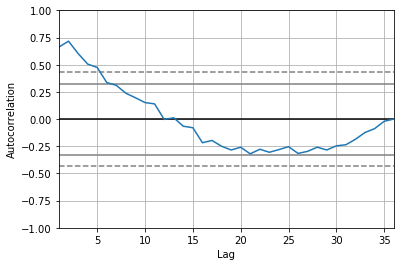

In [105]:
series = read_csv('shampoo_sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
autocorrelation_plot(series)
pyplot.show()

# First 10 ~ 12 lags are positive
# First 5 lags are higher than the dash line
# So, this is AR model, and the param for AR can start with 5

In [40]:
# Check Stationary
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12,center=False).mean()
    rolstd = timeseries.rolling(window=12,center=False).std()

    #Plot rolling statistics:
    plt.figure(figsize=(9,7))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='green', label='Rolling Mean')
    std = plt.plot(rolstd, color='red', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

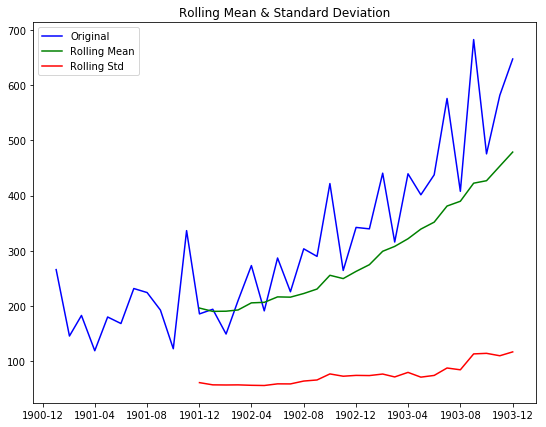

Results of Dickey-Fuller Test:
Test Statistic                  3.060142
p-value                         1.000000
#Lags Used                     10.000000
Number of Observations Used    25.000000
Critical Value (5%)            -2.986489
Critical Value (1%)            -3.723863
Critical Value (10%)           -2.632800
dtype: float64


In [41]:
test_stationarity(series)

In [25]:
# From the above output, we can see:
## Mean is changing over the time, although variance stays more constant -> non-stationary
## Test Statistics is higher than Critical Value -> non-statioary

# So here comes data preprocessing, to Make It Stationary
import numpy as np

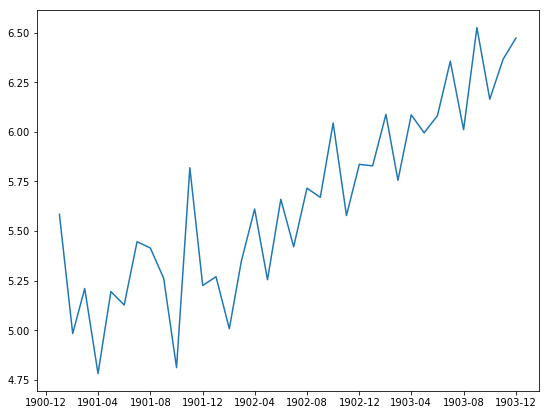

In [29]:
# Make It Stationary - First Trick - Log Transform, to reduce trend
## Original data is all positive, taking log() is fine

ts_log = np.log(series)
plt.figure(figsize=(9,7))
plt.plot(ts_log)
plt.show()

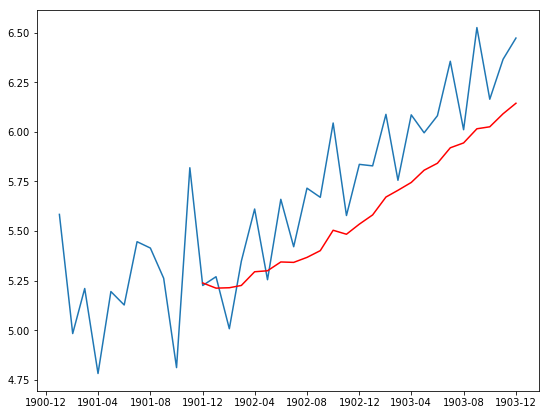

In [35]:
# Make It Stationary Mehtod 1 - Moving Average [Eliminate Trend Only]

moving_avg = ts_log.rolling(window=12,center=False).mean()  # taking average of LAST 2 years (36-12) values
plt.figure(figsize=(9,7))
plt.plot(ts_log)
plt.plot(moving_avg, color='red')
plt.show()

In [36]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(12)   # rolling mean is not defined in the first 12 values, it's YEARLY average

Month
1901-01-01        NaN
1901-02-01        NaN
1901-03-01        NaN
1901-04-01        NaN
1901-05-01        NaN
1901-06-01        NaN
1901-07-01        NaN
1901-08-01        NaN
1901-09-01        NaN
1901-10-01        NaN
1901-11-01        NaN
1901-12-01   -0.01281
Name: Sales of shampoo over a three year period, dtype: float64

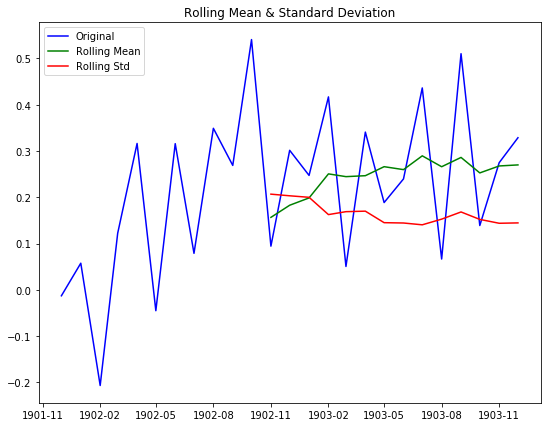

Results of Dickey-Fuller Test:
Test Statistic                 -2.866638
p-value                         0.049367
#Lags Used                      8.000000
Number of Observations Used    16.000000
Critical Value (5%)            -3.068498
Critical Value (1%)            -3.924019
Critical Value (10%)           -2.673893
dtype: float64


In [42]:
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

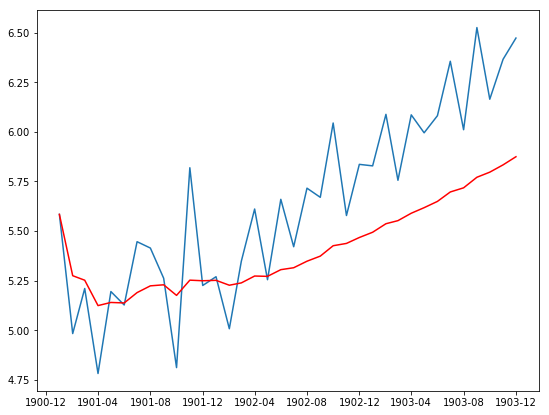

In [45]:
# Make It Stationary Mehtod 2 - Weighted Moving Average [Eliminate Trend Only]

expwighted_avg = ts_log.ewm(halflife=12,ignore_na=False,min_periods=0,adjust=True).mean()
plt.figure(figsize=(9,7))
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')
plt.show()

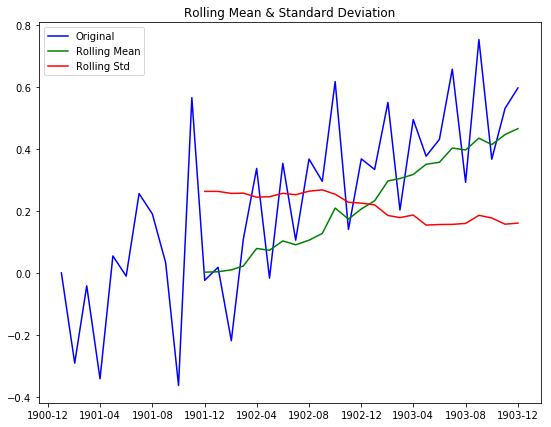

Results of Dickey-Fuller Test:
Test Statistic                 -0.945353
p-value                         0.772671
#Lags Used                     10.000000
Number of Observations Used    25.000000
Critical Value (5%)            -2.986489
Critical Value (1%)            -3.723863
Critical Value (10%)           -2.632800
dtype: float64


In [46]:
ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff)

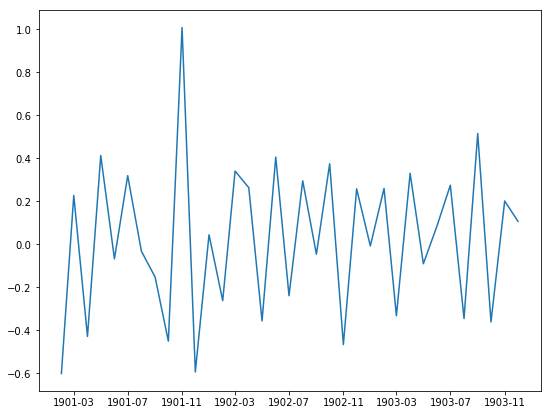

In [47]:
# Make It Stationary Method 3 [Eliminating Trend and Seasonality]
## Differencing – taking the differece with a particular time lag 

ts_log_diff = ts_log - ts_log.shift()
plt.figure(figsize=(9,7))
plt.plot(ts_log_diff)
plt.show()

In [48]:
ts_log_diff.head()

Month
1901-01-01         NaN
1901-02-01   -0.600575
1901-03-01    0.227111
1901-04-01   -0.428391
1901-05-01    0.412981
Name: Sales of shampoo over a three year period, dtype: float64

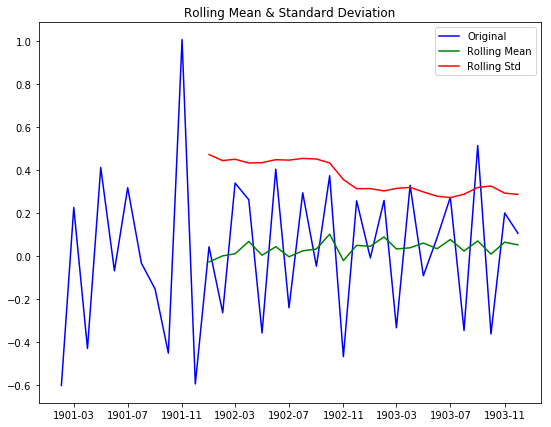

Results of Dickey-Fuller Test:
Test Statistic                 -2.168202
p-value                         0.217988
#Lags Used                     10.000000
Number of Observations Used    24.000000
Critical Value (5%)            -2.992216
Critical Value (1%)            -3.737709
Critical Value (10%)           -2.635747
dtype: float64


In [56]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

# It's better than the above 2 methods (for this case), basde on the plot
# Although Test Statistics is still higher than all the  Critical Value, it's closer

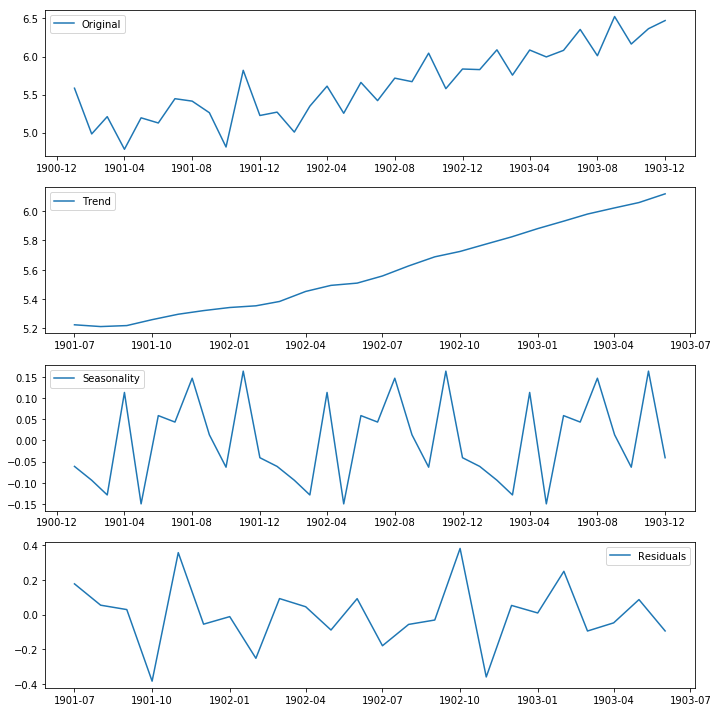

In [57]:
# Make It Stationary Method 4 [Eliminating Trend and Seasonality]
## Decoposing - trend and seasonality are modeled separately and the remaining part of the series is returned

from statsmodels.tsa.seasonal import seasonal_decompose

# trend, seasonality are separated out from data, and we can model the residuals
decomposition = seasonal_decompose(ts_log)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(10,10))
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

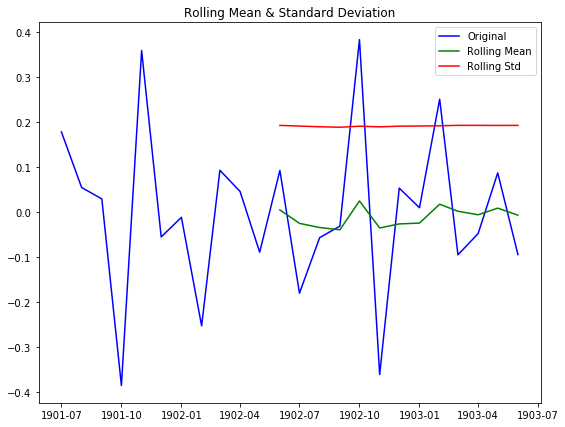

Results of Dickey-Fuller Test:
Test Statistic                 -1.344175
p-value                         0.608728
#Lags Used                      9.000000
Number of Observations Used    14.000000
Critical Value (5%)            -3.104184
Critical Value (1%)            -4.012034
Critical Value (10%)           -2.690987
dtype: float64


In [58]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

In [ ]:
# None of the above 4 methods could make this piece of data stationary
# Maybe we need more years of data in practice

                                          ARIMA Model Results                                          
Dep. Variable:     D.Sales of shampoo over a three year period   No. Observations:                   35
Model:                                          ARIMA(5, 1, 0)   Log Likelihood                -196.170
Method:                                                css-mle   S.D. of innovations             64.241
Date:                                         Sat, 16 Sep 2017   AIC                            406.340
Time:                                                 18:03:43   BIC                            417.227
Sample:                                             02-01-1901   HQIC                           410.098
                                                  - 12-01-1903                                         
                                                        coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------

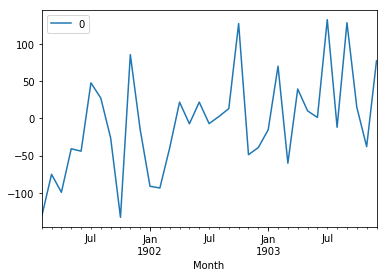

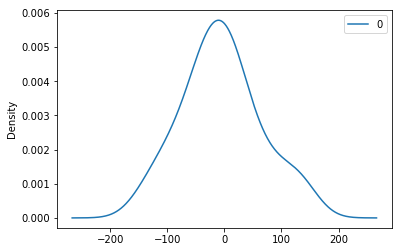

                0
count   35.000000
mean    -5.495234
std     68.132881
min   -133.296613
25%    -42.477967
50%     -7.186668
75%     24.748316
max    133.237956


In [23]:
# try ARIMA model on the original data
# AR model with p=5, q=0 (not MA model), d=1 means using difference order as 1 to make the time series statinoary

series = read_csv('shampoo_sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

# fit model
model = ARIMA(series, order=(5,1,0))
model_fit = model.fit(disp=0)  # with disp=0, we are turning off the debug info about fitting the linear regression
print(model_fit.summary())

# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

In [13]:
#  The first line plot if the plot of the residual errors, 
## suggesting that there may still be some trend information not captured by the model.

# The second plot, a density plot of the residual error values, 
## suggesting the errors are Gaussian, but may not be centered on zero.

# The last output is the distribution of the residual errors is displayed
## non-zero mean indicates that, there is bias in prediction

In [16]:
# forecast

series = read_csv('shampoo_sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
series.values

array([ 266. ,  145.9,  183.1,  119.3,  180.3,  168.5,  231.8,  224.5,
        192.8,  122.9,  336.5,  185.9,  194.3,  149.5,  210.1,  273.3,
        191.4,  287. ,  226. ,  303.6,  289.9,  421.6,  264.5,  342.3,
        339.7,  440.4,  315.9,  439.3,  401.3,  437.4,  575.5,  407.6,
        682. ,  475.3,  581.3,  646.9])

predicted=387.376402, expected=440.400000
predicted=348.154152, expected=315.900000
predicted=386.308838, expected=439.300000
predicted=356.082001, expected=401.300000
predicted=446.379518, expected=437.400000
predicted=394.737272, expected=575.500000
predicted=434.915447, expected=407.600000
predicted=507.923421, expected=682.000000
predicted=435.482775, expected=475.300000
predicted=652.743812, expected=581.300000
predicted=546.343528, expected=646.900000
Test MSE: 8119.126


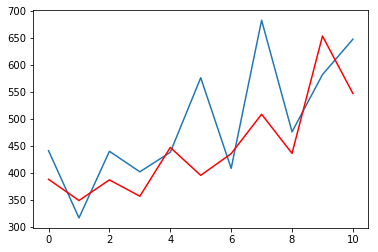

In [21]:
from sklearn.metrics import mean_squared_error

X = series.values
size = int(len(X) * 0.7)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    y_pred = output[0]
    predictions.append(y_pred)
    obs = test[t]
    history.append(obs)  # The observation value in the last run will be put as the history for the next run
    print('predicted=%f, expected=%f' % (y_pred, obs))  # compare each prediction and observation
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

# plot the forecast
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

In [60]:
# try ARIMA model on differenting output, since it gave best result above

from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

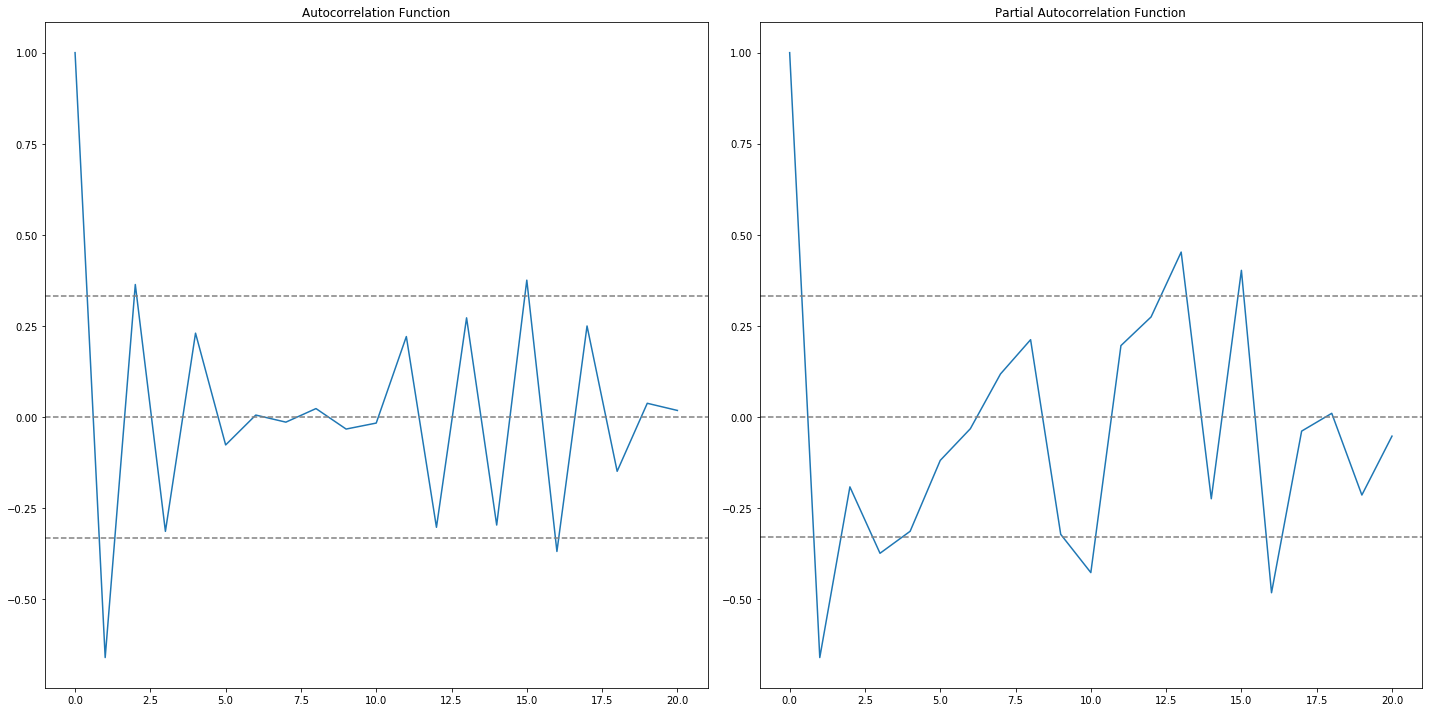

In [69]:
plt.figure(figsize=(20,10))

#Plot ACF: 
## q – The lag value where the ACF chart crosses the upper confidence interval for the first time (in this case q=1)
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
## p – The lag value where the PACF chart crosses the upper confidence interval for the first time (in this case p=1)
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()
plt.show()

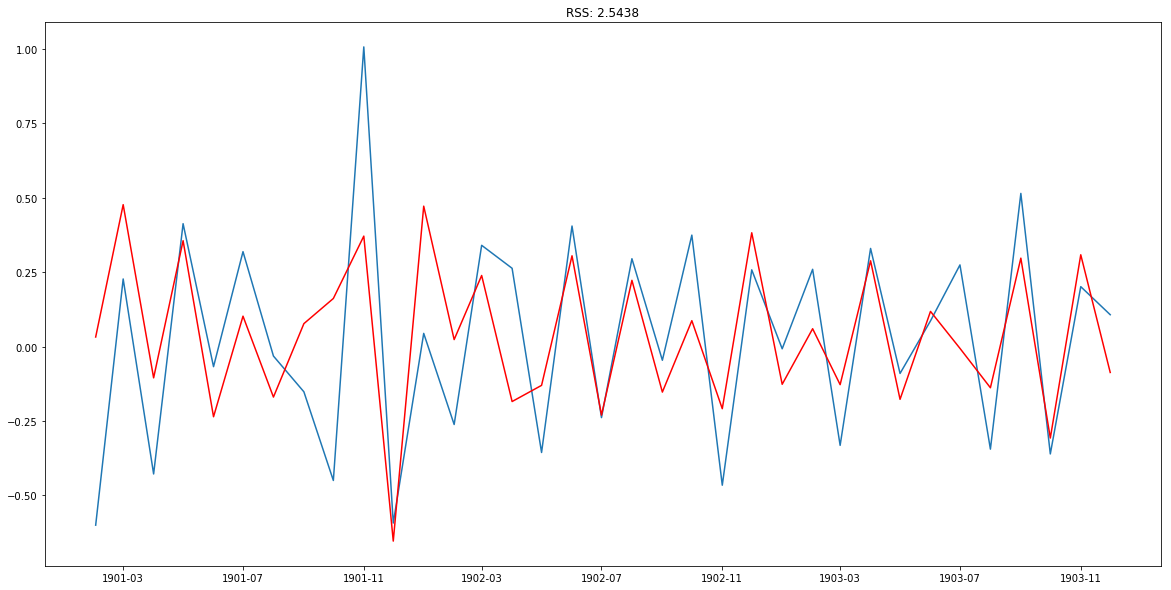

In [80]:
from statsmodels.tsa.arima_model import ARIMA
# RSS is for the values of residuals

# AR model
model = ARIMA(ts_log, order=(1, 1, 0))  
results_AR = model.fit(disp=-1) 
plt.figure(figsize=(20,10))
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))
plt.show()

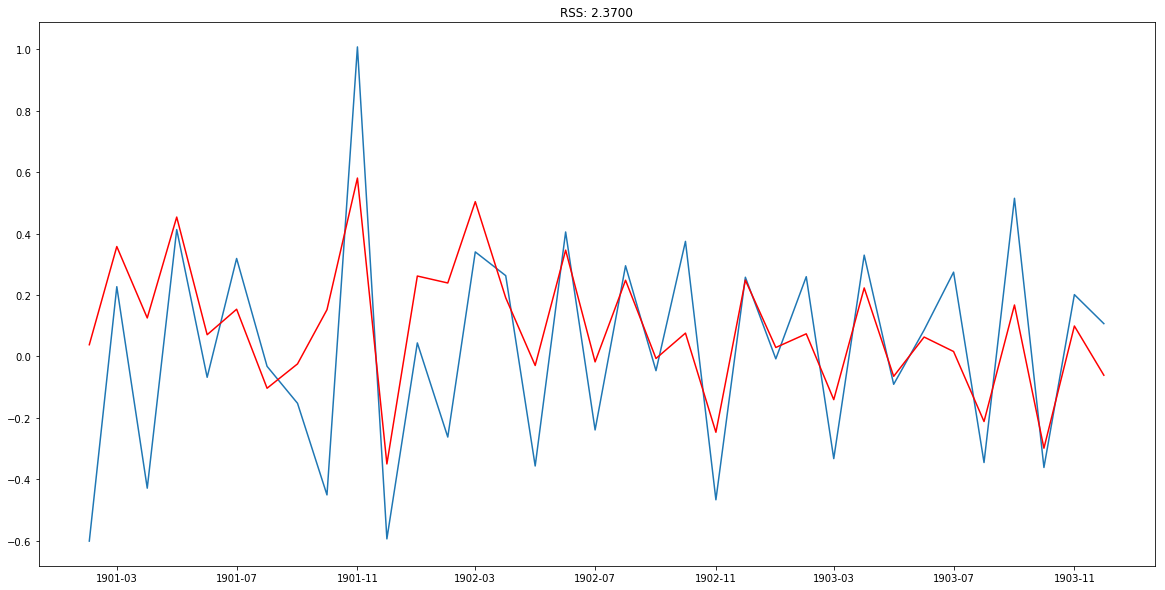

In [79]:
# MA Model

model = ARIMA(ts_log, order=(0, 1, 1))  
results_MA = model.fit(disp=-1)  
plt.figure(figsize=(20,10))
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))
plt.show()

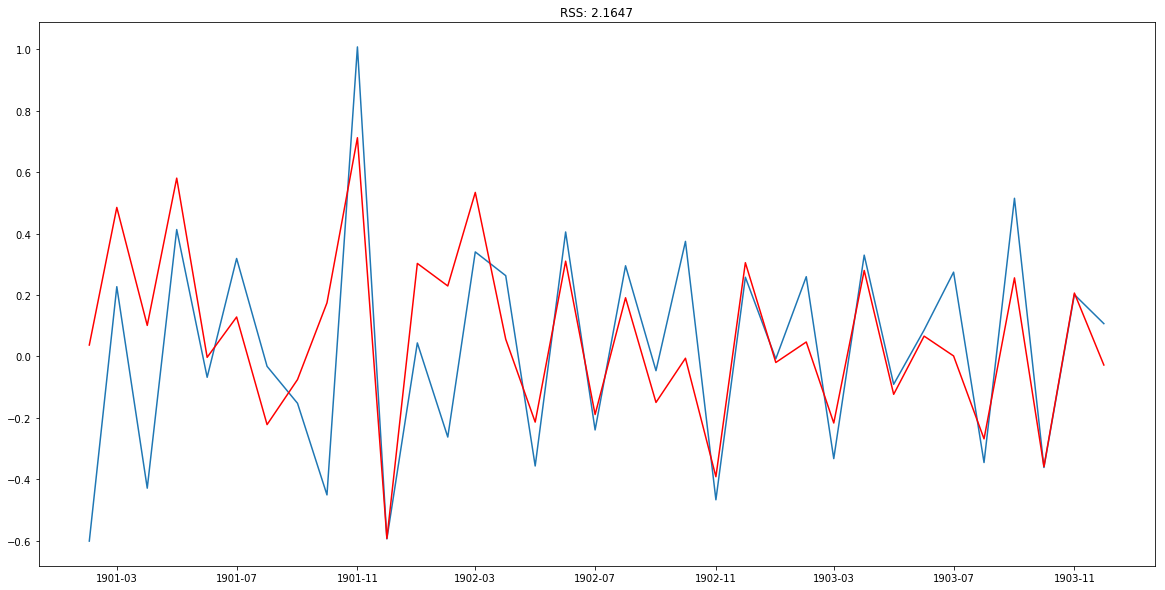

In [100]:
# combined mobel

model = ARIMA(ts_log, order=(1, 1, 1))  
results_ARIMA = model.fit(disp=-1)  
plt.figure(figsize=(20,10))
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))
plt.show()

In [101]:
# As we can see based on RSS (sum of resuduals)
## Scale back to original value, and see how this combined value performs

# Step 1 - store predicted result as seperated result
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print predictions_ARIMA_diff.head()

# start with 1901-02-01 is because we took the lag by 1, first element has nothing to subtract

Month
1901-02-01    0.037293
1901-03-01    0.484970
1901-04-01    0.101135
1901-05-01    0.580283
1901-06-01   -0.002748
dtype: float64


In [102]:
# Step 2 - Convert the differencing to log scale
## Add these differences consecutively to the base number
## An easy way to do it is to first determine the cumulative sum at index and then add it to the base number

predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print predictions_ARIMA_diff_cumsum.head()

Month
1901-02-01    0.037293
1901-03-01    0.522263
1901-04-01    0.623399
1901-05-01    1.203682
1901-06-01    1.200934
dtype: float64


In [103]:
predictions_ARIMA_log = pd.Series(ts_log.iloc[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

Month
1901-01-01    5.583496
1901-02-01    5.620790
1901-03-01    6.105760
1901-04-01    6.206895
1901-05-01    6.787178
dtype: float64

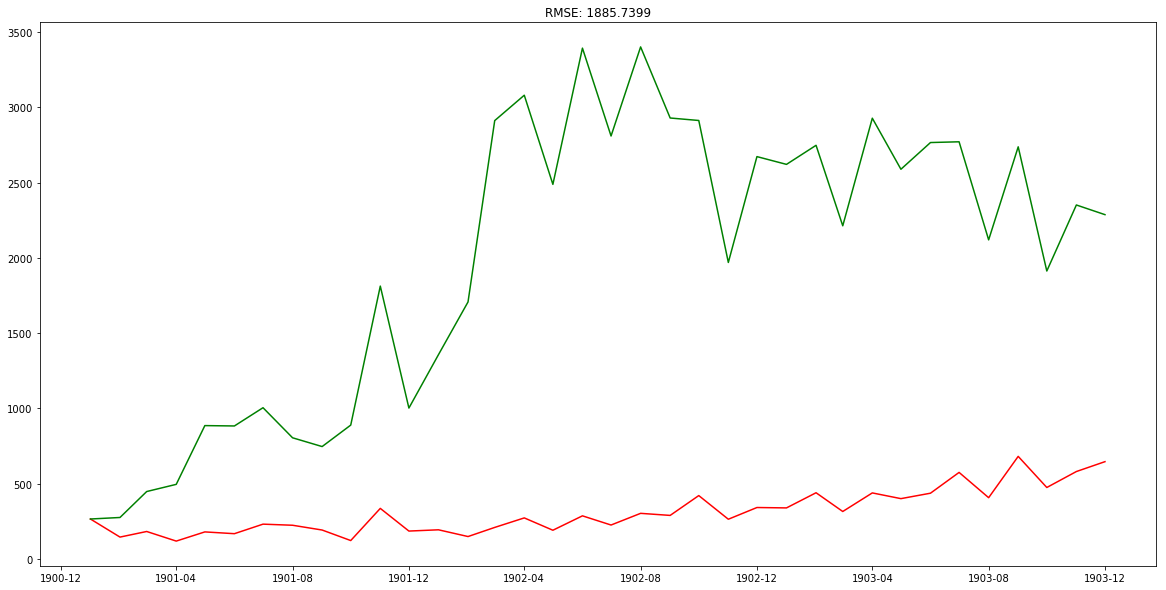

In [107]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.figure(figsize=(20,10))
plt.plot(series, color='red')
plt.plot(predictions_ARIMA, color='green')
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-series)**2)/len(series)))
plt.show()

In [ ]:
# The forecast result is not really good.... Maybe the training data needs more years